# Newsvendor Intro Example

In [1]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":18,
    "font.family": "serif"
})
colors = ["tab:blue", "tab:green", "tab:orange", 
          "blue", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "red"]

In [2]:
def pareto_frontier(Xs, Ys, maxX = False, maxY = False):
    Xs = np.array(Xs)
    Ys = np.array(Ys)
# Sort the list in either ascending or descending order of X
    myList = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxX)
# Start the Pareto frontier with the first value in the sorted list
    p_front = [myList[0]]    
# Loop through the sorted list
    for pair in myList[1:]:
        if maxY: 
            if pair[1] >= p_front[-1][1]: # Look for higher values of Y…
                p_front.append(pair) # … and add them to the Pareto frontier
        else:
            if pair[1] <= p_front[-1][1]: # Look for lower values of Y…
                p_front.append(pair) # … and add them to the Pareto frontier
# Turn resulting pairs back into a list of Xs and Ys
    p_frontX = [pair[0] for pair in p_front]
    p_frontY = [pair[1] for pair in p_front]
    return p_frontX, p_frontY

### Example 1: Intro example, max of affine uncertainty
We consider a problem with max of affine uncertainty, 

$$g(u,x) = \max_{l=1,\dots,L} (P_lu + a_l)^Tx,$$
where $P_l$ and $a_l$ are constants for all $l = 1, \dots, L$. The robust formulation is 
$$
\begin{array}{ll}
\text{minimize} & \tau\\
\text{subject to}  & \max_{l=1,\dots,L} (P_lu + a_l)^Tx  \leq  \tau \quad \forall u \in \mathcal{U}(\theta)\\
& x \geq 0,
\end{array}
$$


where $\theta$ encodes the training parameters $(A,b)$.

We formulate the Newsvendor problem with this framework, where we solve
\begin{equation}
	\begin{array}{ll}
		\text{minimize} & \tau\\
		\text{subject to} & k^Tx  + \max\{-p^Tx,- p^Tu\} \le \tau \quad \forall u \in \mathcal{U}(\theta) \\
		& x \geq 0.
	\end{array}
\end{equation}

In [3]:
# Formulate constants
n = 2
N = 5000
test_perc = 0.99
# k = npr.uniform(1,4,n)
# p = k + npr.uniform(2,5,n)
k = np.array([4.,5.])
p = np.array([5,6.5])
# k_tch = torch.tensor(k, requires_grad = True)
# p_tch = torch.tensor(p, requires_grad = True)

def loss(t,x,k_tch, p_tch, alpha,data, mu = 1, l = 5, quantile = 0.95,target = 1.): 
    sums = torch.mean(torch.maximum(
        torch.maximum( k_tch@x -data@(p_tch), k_tch@x - x@(p_tch)) - t - alpha, 
        torch.tensor(0.,requires_grad = True)))
    sums = sums/(1-quantile) + alpha
    return t + l*(sums - target) + (mu/2)*(sums - target)**2, t, torch.mean((torch.maximum(
        torch.maximum(k_tch@x -data@(p_tch), k_tch@x - x@(p_tch)) - t, 
        torch.tensor(0.,requires_grad = True))>=0.001).float()), sums.detach().numpy()

def gen_demand_intro(N, seed):
    np.random.seed(seed)
    sig = np.array([[0.6,-0.4],[-0.3,0.1]])
    mu = np.array((0.9,0.7))
    norms = np.random.multivariate_normal(mu,sig, N)
    d_train = np.exp(norms)
    return d_train


# Generate data
data = gen_demand_intro(N, seed=5)
data_train = data[:int((1-test_perc)*N),:]


In [4]:
scenarios = {}
num_scenarios = 3
for scene in range(num_scenarios):
  np.random.seed(scene)
  scenarios[scene]={}
  scenarios[scene][0] = k
  scenarios[scene][1] = p + np.random.normal(0,1,2)

scenarios = {}
num_scenarios = 8
for scene in range(num_scenarios):
  np.random.seed(scene+1)
  scenarios[scene]={}
  scenarios[scene][0] = np.random.uniform(2,6,n)
  scenarios[scene][1] =  scenarios[scene][0] + np.random.uniform(2,4,n)

# scenarios = {}
# num_scenarios = 1
# for scene in range(num_scenarios):
#   np.random.seed(scene)
#   scenarios[scene]={}
#   scenarios[scene][0] = k
#   scenarios[scene][1] = p

In [5]:
# Formulate uncertainty set
u = lropt.UncertainParameter(n,
                        uncertainty_set=lropt.Ellipsoidal(p=2,
                                                    data=data, loss = loss))
# Formulate the Robust Problem
x_r = cp.Variable(n)
t = cp.Variable()
k = cp.Parameter(2)
p = cp.Parameter(2)
k.value = scenarios[0][0]
p.value = scenarios[0][1]
# y = cp.Variable()

objective = cp.Minimize(t)

constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
constraints += [x_r >= 0]

prob = lropt.RobustProblem(objective, constraints)
target = -0.1
s = 13

# setup intial A, b
train, test = train_test_split(data, test_size=int(data.shape[0]*test_perc), random_state=s)
init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
init_bval = -init@np.mean(train, axis=0)

# Train A and b
result1 = prob.train(lr = 0.001, step=100, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, fixb = False, init_mu = 1, init_lam = 0, target_cvar = target, init_alpha = -0.1, test_percentage = test_perc, save_iters= True, scenarios = scenarios, num_scenarios = num_scenarios, max_inner_iter = 15)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b
A1_iters, b1_iters = result1.uncset_iters

result2 = prob.train(eps = True, lr = 0.001, step= 100, momentum = 0.8, optimizer = "SGD", seed = s, init_A = A_fin, init_b = b_fin, init_mu = 1, init_lam = 0, target_cvar = target, init_alpha = -0.1, test_percentage = test_perc,scenarios = scenarios, num_scenarios = num_scenarios,max_inner_iter = 1)
df_r1 = result2.df

result3 = prob.train(eps = True, lr = 0.001, step=100, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, init_mu = 1, init_lam = 0,  target_cvar = target, init_alpha  =-0.1, test_percentage = test_perc,scenarios = scenarios, num_scenarios = num_scenarios,max_inner_iter = 1)
df_r2 = result3.df

# Grid search standard
result4 = prob.grid(epslst = np.linspace(0.01, 2.98, 40), init_A = result3.A, init_b = result3.b, seed = s, init_alpha = -0., test_percentage = test_perc,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid = result4.df

# Grid search reshaped
result5 = prob.grid(epslst = np.linspace(0.01, 2.98, 40), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = -0., test_percentage = test_perc,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid2 = result5.df

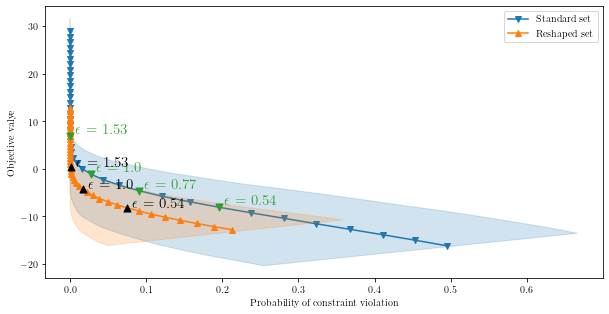

In [6]:
eps_list = np.linspace(0.01, 2.98, 40)
inds = [20,13,10,7]

plt.figure(figsize=(10, 5))
plt.plot(np.mean(np.vstack(dfgrid['Violations']),axis = 1)[:], np.mean(np.vstack(dfgrid['Test_val']),axis = 1)[:], color="tab:blue", label=r"Standard set", marker = "v",zorder=0)
plt.fill(np.append(np.quantile(np.vstack(dfgrid['Violations']),0.1,axis = 1),np.quantile(np.vstack(dfgrid['Violations']),0.9,axis = 1)[::-1]), np.append(np.quantile(np.vstack(dfgrid['Test_val']),0.1,axis = 1),np.quantile(np.vstack(dfgrid['Test_val']),0.90,axis = 1)[::-1]), color="tab:blue", alpha=0.2)
for ind in range(4):
    plt.scatter(np.mean(np.vstack(dfgrid['Violations']),axis = 1)[inds[ind]],np.mean(np.vstack(dfgrid['Test_val']),axis = 1)[inds[ind]], color="tab:green", s = 50, marker = "v",zorder= 10)
    plt.annotate(r"$\epsilon$ = {}".format(round(eps_list[inds[ind]],2)), # this is the text
                  (np.mean(np.vstack(dfgrid['Violations']),axis = 1)[inds[ind]],np.mean(np.vstack(dfgrid['Test_val']),axis = 1)[inds[ind]]), # these are the coordinates to position the label
                  textcoords="offset points", # how to position the text
                  xytext=(5,3), # distance from text to points (x,y)
                  ha='left',color="tab:green",fontsize=15) 

plt.plot(np.mean(np.vstack(dfgrid2['Violations']),axis = 1),np.mean(np.vstack(dfgrid2['Test_val']),axis = 1), color="tab:orange", label="Reshaped set", marker = "^",zorder=1)
plt.fill(np.append(np.quantile(np.vstack(dfgrid2['Violations']),0.1,axis = 1),np.quantile(np.vstack(dfgrid2['Violations']),0.9,axis = 1)[::-1]), np.append(np.quantile(np.vstack(dfgrid2['Test_val']),0.1,axis = 1),np.quantile(np.vstack(dfgrid2['Test_val']),0.90,axis = 1)[::-1]), color="tab:orange", alpha=0.2)
for ind in [0,1,3]:
    plt.scatter(np.mean(np.vstack(dfgrid2['Violations']),axis = 1)[inds[ind]],np.mean(np.vstack(dfgrid2['Test_val']),axis = 1)[inds[ind]], color="black", s = 50, marker = "^")
    plt.annotate(r"$\epsilon$ = {}".format(round(eps_list[inds[ind]],2)), # this is the text
                  (np.mean(np.vstack(dfgrid2['Violations']),axis = 1)[inds[ind]],np.mean(np.vstack(dfgrid2['Test_val']),axis = 1)[inds[ind]]), # these are the coordinates to position the label
                  textcoords="offset points", # how to position the text
                  xytext=(5,1), # distance from text to points (x,y)
                  ha='left',color="black", fontsize = 15) 
plt.ylabel("Objective valye")
# ax2.set_xlim([-1,20])
plt.xlabel("Probability of constraint violation")
plt.legend()
# lgd = plt.legend(loc = "lower right", bbox_to_anchor=(1.5, 0.3))
plt.savefig("ex1_curves_orig.pdf", bbox_inches='tight')
# plt.savefig("ex1_curves1.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')


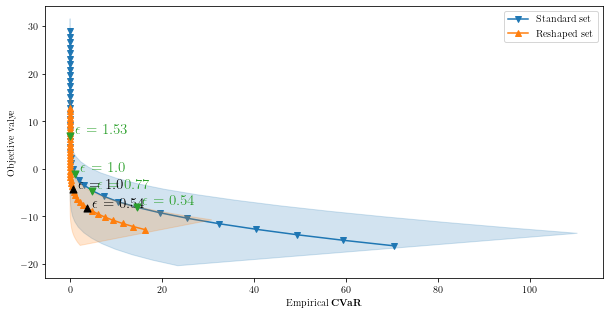

In [7]:
eps_list = np.linspace(0.01, 2.98, 40)
inds = [20,13,10,7]
plt.figure(figsize=(10, 5))
plt.plot(np.mean(np.vstack(dfgrid['Violation_val']),axis = 1)[:], np.mean(np.vstack(dfgrid['Test_val']),axis = 1)[:], color="tab:blue", label=r"Standard set", marker = "v",zorder=0)
plt.fill(np.append(np.quantile(np.vstack(dfgrid['Violation_val']),0.1,axis = 1),np.quantile(np.vstack(dfgrid['Violation_val']),0.9,axis = 1)[::-1]), np.append(np.quantile(np.vstack(dfgrid['Test_val']),0.1,axis = 1),np.quantile(np.vstack(dfgrid['Test_val']),0.90,axis = 1)[::-1]), color="tab:blue", alpha=0.2)
for ind in range(4):
    plt.scatter(np.mean(np.vstack(dfgrid['Violation_val']),axis = 1)[inds[ind]],np.mean(np.vstack(dfgrid['Test_val']),axis = 1)[inds[ind]], color="tab:green", s = 50, marker = "v",zorder= 10)
    plt.annotate(r"$\epsilon$ = {}".format(round(eps_list[inds[ind]],2)), # this is the text
                  (np.mean(np.vstack(dfgrid['Violation_val']),axis = 1)[inds[ind]],np.mean(np.vstack(dfgrid['Test_val']),axis = 1)[inds[ind]]), # these are the coordinates to position the label
                  textcoords="offset points", # how to position the text
                  xytext=(5,3), # distance from text to points (x,y)
                  ha='left',color="tab:green",fontsize=15) 

plt.plot(np.mean(np.vstack(dfgrid2['Violation_val']),axis = 1),np.mean(np.vstack(dfgrid2['Test_val']),axis = 1), color="tab:orange", label="Reshaped set", marker = "^",zorder=1)
plt.fill(np.append(np.quantile(np.vstack(dfgrid2['Violation_val']),0.1,axis = 1),np.quantile(np.vstack(dfgrid2['Violation_val']),0.9,axis = 1)[::-1]), np.append(np.quantile(np.vstack(dfgrid2['Test_val']),0.1,axis = 1),np.quantile(np.vstack(dfgrid2['Test_val']),0.90,axis = 1)[::-1]), color="tab:orange", alpha=0.2)
for ind in [1,3]:
    plt.scatter(np.mean(np.vstack(dfgrid2['Violation_val']),axis = 1)[inds[ind]],np.mean(np.vstack(dfgrid2['Test_val']),axis = 1)[inds[ind]], color="black", s = 50, marker = "^")
    plt.annotate(r"$\epsilon$ = {}".format(round(eps_list[inds[ind]],2)), # this is the text
                  (np.mean(np.vstack(dfgrid2['Violation_val']),axis = 1)[inds[ind]],np.mean(np.vstack(dfgrid2['Test_val']),axis = 1)[inds[ind]]), # these are the coordinates to position the label
                  textcoords="offset points", # how to position the text
                  xytext=(5,1), # distance from text to points (x,y)
                  ha='left',color="black", fontsize = 15) 
plt.ylabel("Objective valye")
# ax2.set_xlim([-1,20])
plt.xlabel("Empirical $\mathbf{CVaR}$")
plt.legend()
# lgd = plt.legend(loc = "lower right", bbox_to_anchor=(1.5, 0.3))
plt.savefig("ex1_cvar.pdf", bbox_inches='tight')
# plt.savefig("ex1_curves1.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')


In [8]:
k = np.array([4.,5.])
p = np.array([5,6.5])
x_opt_base = {}
x_opt_learned = {}
t_learned = {}
t_base = {}
for ind in range(4):
    x_opt_base[ind] = {}
    x_opt_learned[ind] = {}
    t_learned[ind] = {}
    t_base[ind] = {}
    for scene in range(num_scenarios):
        n = 2
        u = lropt.UncertainParameter(n,
                                uncertainty_set=lropt.Ellipsoidal(p=2,
                                                            A = (1/eps_list[inds[ind]])*result3.A, b = (1/eps_list[inds[ind]])*result3.b))
        # Formulate the Robust Problem
        x_r = cp.Variable(n)
        t = cp.Variable()
        k = scenarios[scene][0]
        p = scenarios[scene][1]
        # y = cp.Variable()

        objective = cp.Minimize(t)

        constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
        # constraints += [cp.maximum(k1@(x_r-u),0) <= y]
        # constraints = [cp.maximum(u@k + k1@x_r -u@(k + k1), u@k + k1@x_r - x_r@(k + k1))<=t]

        constraints += [x_r >= 0]

        prob = lropt.RobustProblem(objective, constraints)
        prob.solve()
        # result3.reform_problem.solve()
        x_opt_base[ind][scene] = x_r.value

        t_base[ind][scene] = t.value

        n = 2
        u = lropt.UncertainParameter(n,
                                uncertainty_set=lropt.Ellipsoidal(p=2,
                                                            A = (1/eps_list[inds[ind]])*A_fin, b = (1/eps_list[inds[ind]])*b_fin))
        # Formulate the Robust Problem
        x_r = cp.Variable(n)
        t = cp.Variable()
        k = scenarios[scene][0]
        p = scenarios[scene][1]
        # y = cp.Variable()

        objective = cp.Minimize(t)

        constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
        # constraints += [cp.maximum(k1@(x_r-u),0) <= y]
        # constraints = [cp.maximum(u@k + k1@x_r -u@(k + k1), u@k + k1@x_r - x_r@(k + k1))<=t]

        constraints += [x_r >= 0]

        prob = lropt.RobustProblem(objective, constraints)
        prob.solve()
        # result3.reform_problem.solve()
        x_opt_learned[ind][scene] = x_r.value

        t_learned[ind][scene] = t.value
        x_opt_learned,x_opt_base,t_learned, t_base
    # A_fin, init, b_fin, init_bval
# x_opt_learned,x_opt_base,t_learned, t_base
A_fin, b_fin, init, init_bval

(array([[0.71052342, 0.08134776],
        [0.35783315, 0.95602674]]),
 array([-1.81298963, -2.82988345]),
 array([[0.35029562, 0.15733994],
        [0.15733994, 1.03055715]]),
 array([-1.65405866, -2.63233048]))

Text(0.5, 0.98, 'Standard set')

<Figure size 360x360 with 0 Axes>

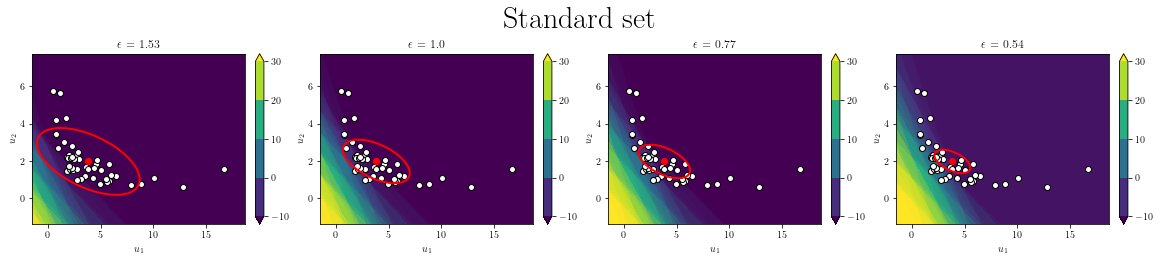

In [9]:
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"
K =1
plt.figure(figsize=(5, 5))
num_p = 50
offset = 2
x_min, x_max = np.min(train[:,0]) - offset, np.max(train[:,0]) + offset
y_min, y_max = np.min(train[:,1]) - offset, np.max(train[:,1]) + offset
X = np.linspace(x_min,x_max,num_p)
Y = np.linspace(y_min,y_max,num_p)
x,y = np.meshgrid(X,Y)
# Z values as a matrix
fin_set = {}
init_set = {}
for ind in range(4):
    fin_set[ind] = {}
    init_set[ind] = {}
    for k_ind in range(K):
        fin_set[ind][k_ind] = np.zeros((num_p,num_p))
        init_set[ind][k_ind] = np.zeros((num_p,num_p))
g_level_learned = {}
g_level_base = {}
for ind in range(4):
    g_level_learned[ind] = {}
    g_level_base[ind] = {}
    for scene in range(num_scenarios):
        g_level_learned[ind][scene] = np.zeros((num_p,num_p))
        g_level_base[ind][scene] = np.zeros((num_p,num_p))
# init_set = np.zeros((num_p,num_p))
    # Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
    for i in range(num_p):
        for j in range(num_p):
            u_vec = [x[i,j], y[i,j]]
            for k_ind in range(K):
                fin_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds[ind]])*A_fin[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec + (1/eps_list[inds[ind]])*b_fin)

            for k_ind in range(K):
                init_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds[ind]])*result3.A[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec  + (1/eps_list[inds[ind]])*result3.b)
            
            for scene in range(num_scenarios):
                g_level_learned[ind][scene][i,j] = np.maximum(scenarios[scene][0] @ x_opt_learned[ind][scene] - scenarios[scene][1] @ x_opt_learned[ind][scene], scenarios[scene][0] @ x_opt_learned[ind][scene] - scenarios[scene][1] @ u_vec) - t_learned[ind][scene]
                g_level_base[ind][scene][i,j] = np.maximum(scenarios[scene][0] @ x_opt_base[ind][scene] - scenarios[scene][1] @ x_opt_base[ind][scene], scenarios[scene][0] @ x_opt_base[ind][scene] - scenarios[scene][1] @ u_vec) - t_base[ind][scene]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3.5), constrained_layout= True)
ax_lst = [ax1, ax2, ax3, ax4]

cur_ind = 0
contours = []
for axis in ax_lst:
    axis.set_title(r"$\epsilon$ = {}".format(round(eps_list[inds[cur_ind]],2)))
    axis.set_xlabel(r"$u_1$")
    axis.set_ylabel(r"$u_2$")
    for k_ind in range(K):
        axis.contour(x,y,init_set[cur_ind][k_ind], [1], colors = ["red"],linewidths = [2])

    a1 = axis.contourf(x,y,g_level_base[cur_ind][0],np.arange(-10, 40, 10),extend='both',alpha = 1)
    contours.append(a1)
    for scene in range(1,num_scenarios):
        a1 = axis.contourf(x,y,g_level_base[cur_ind][scene],np.arange(-10, 40, 10),extend='both',alpha = 0.3)
        contours.append(a1)
    axis.scatter(train[:,0],train[:,1], color = "white" ,edgecolors= "black")
    axis.scatter(np.mean(train,axis= 0)[0], np.mean(train,axis= 0)[1],color = ["red"])
    cur_ind +=1
    fig.colorbar(contours[0], ax = axis)

fig.suptitle("Standard set", fontsize = 30)

# plt.savefig("Reshaped1_cons2.pdf", bbox_inches='tight')


Text(0.5, 0.98, 'Reshaped set')

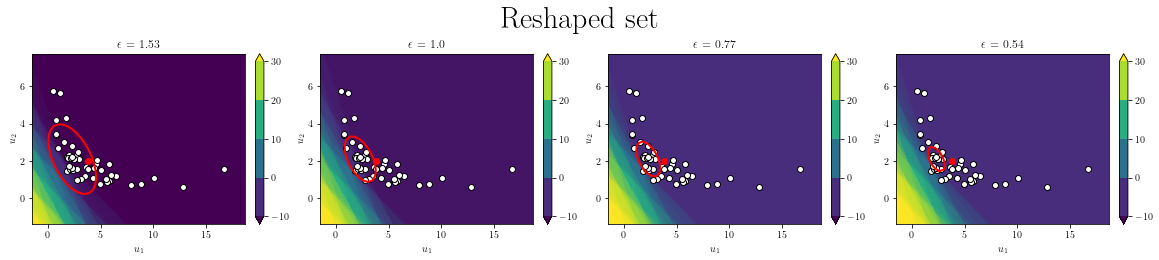

In [10]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3.5), constrained_layout= True)
ax_lst = [ax1, ax2, ax3, ax4]
cur_ind = 0
contours = []
for axis in ax_lst:
    axis.set_title(r"$\epsilon$ = {}".format(round(eps_list[inds[cur_ind]],2)))
    axis.set_xlabel(r"$u_1$")
    axis.set_ylabel(r"$u_2$")
    for k_ind in range(K):
        axis.contour(x,y,fin_set[cur_ind][k_ind], [1], colors = ["red"],linewidths = [2])
    a1 = axis.contourf(x,y,g_level_learned[cur_ind][0],np.arange(-10, 40, 10),extend='both',alpha = 1)
    contours.append(a1)
    for scene in range(1,num_scenarios):
        a1 = axis.contourf(x,y,g_level_learned[cur_ind][scene],np.arange(-10, 40, 10),extend='both',alpha = 0.3)
        contours.append(a1)
    axis.scatter(train[:,0],train[:,1], color = "white" ,edgecolors= "black")
    axis.scatter(np.mean(train,axis= 0)[0], np.mean(train,axis= 0)[1],color = ["red"])
    fig.colorbar(contours[0], ax = axis)
    cur_ind +=1
fig.suptitle("Reshaped set", fontsize = 30)

# plt.savefig("Reshaped2_cons2.pdf", bbox_inches='tight')
